In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Input, ReLU, Add, Layer, Activation
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
class MaskConv2D(Conv2D):
    def __init__(self, *args, mask_type = 'B', **kwargs):
        super().__init__(*args, **kwargs)
        self.mask = None
        self.mask_t = mask_type

    def build(self, input_shape):
        super().build(input_shape)
        filter_height, filter_width, filters_input, filters_output = self.kernel.shape
        self.mask = np.ones(self.kernel.shape).astype('f')
        yc, xc = filter_height // 2, filter_width // 2
        self.mask[yc + 1:,] = 0.0
        self.mask[yc, xc + 1:] = 0.0
        if self.mask_t == 'A':
          self.mask[yc, xc] = 0.0
        # else:
          # green = np.zeros(filters_output)
          # blue = np.zeros(filters_output)
          # ind = range(filters_output)
          # red = np.ones(filters_output)
          # green_set = set(ind[1::3])
          # blue_set = set(ind[2::3])
          # green_ind = list(green_set.union(blue_set))
          # blue_ind = list(blue_set)
          # green[green_ind] += 1
          # blue[blue_ind] += 1
          # mat = np.zeros((filters_input, filters_output))
          # self.mask = np.zeros(self.kernel.shape).astype('f')
          # mat[::3] = red
          # mat[1::3] = green
          # mat[2::3] = blue
          # self.mask[yc + 1:,:,] = mat
          # self.mask[yc, xc:,] = mat
    def call(self, x):
        outputs = tf.keras.backend.conv2d(x, self.kernel * self.mask, strides=self.strides, padding=self.padding)
        if self.use_bias:
            outputs = tf.keras.backend.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        return outputs

    def get_config(self):
        return dict(list(super().get_config().items()))

In [ ]:
3 // 2, 3 // 2

(1, 1)

In [ ]:
y = Input((28, 28, 6))
MaskConv2D(7, (3, 3), padding='same', input_shape=y.shape, mask_type='B')(y)


[[1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0.]]


<tf.Tensor 'mask_conv2d_4/Identity:0' shape=(None, 28, 28, 7) dtype=float32>

In [ ]:
def Residualblock(x):
  model = ReLU()(x)

  model = MaskConv2D(64, (1, 1), padding='same', mask_type='B')(model)
  model = ReLU()(model)
  
  model = MaskConv2D(64, (3, 3), padding='same', mask_type='B')(model)
  model = ReLU()(model)

  model = MaskConv2D(128, (1, 1), padding='same', mask_type='B')(model)
  model = Add()([x, model])
  return model


In [ ]:
(X_train, y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
data = np.concatenate((X_train, X_test), axis=0)

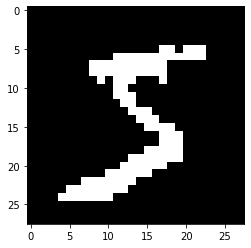

In [ ]:
data = data.astype('float32')
data /= 255
data = np.around(1 - data)
data = data.reshape(data.shape[0], 28, 28, 1)
plt.imshow(data[0, :, :, 0], cmap='Greys')

In [ ]:
shape = (28, 28, 1)

inputs = Input(shape)
model = MaskConv2D(128, (7,7), padding='same', mask_type='A')(inputs)

model = Residualblock(model)
model = ReLU()(model)

model = Residualblock(model)
model = ReLU()(model)

model = Residualblock(model)
model = ReLU()(model)

model = Residualblock(model)
model = ReLU()(model)

model = Residualblock(model)
model = ReLU()(model)

model = MaskConv2D(128, (1,1), padding='same', mask_type='B')(model)
model = ReLU()(model)

model = MaskConv2D(1, (1,1), padding='same', mask_type='B')(model)
outputs = Activation('sigmoid')(model)

model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam")
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
mask_conv2d (MaskConv2D)        (None, 28, 28, 128)  6400        input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 28, 28, 128)  0           mask_conv2d[0][0]                
__________________________________________________________________________________________________
mask_conv2d_1 (MaskConv2D)      (None, 28, 28, 64)   8256        re_lu[0][0]                      
______________________________________________________________________________________________

In [ ]:
model.layers[5].mask[1, 1, :, :]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [ ]:
model.fit(data, data,
      batch_size=32, epochs=10)

Epoch 1/10
2188/2188 [==============================] - 54s 25ms/step - loss: 0.0951
Epoch 2/10
2188/2188 [==============================] - 55s 25ms/step - loss: 0.0865
Epoch 3/10
2188/2188 [==============================] - 54s 25ms/step - loss: 0.0851
Epoch 4/10
2188/2188 [==============================] - 54s 25ms/step - loss: 0.0843
Epoch 5/10
2188/2188 [==============================] - 54s 25ms/step - loss: 0.0837
Epoch 6/10
2188/2188 [==============================] - 54s 25ms/step - loss: 0.0833
Epoch 7/10
2188/2188 [==============================] - 54s 25ms/step - loss: 0.0829
Epoch 8/10
2188/2188 [==============================] - 54s 25ms/step - loss: 0.0827
Epoch 9/10
2188/2188 [==============================] - 54s 25ms/step - loss: 0.0825
Epoch 10/10
2188/2188 [==============================] - 54s 25ms/step - loss: 0.0823


In [ ]:
pixels_new = np.zeros((1, 28, 28, 1))
b, rows, cols, chan = pixels_new.shape
for row in range(rows):
    for col in range(cols):
        predict = model.predict(pixels_new)
        p = predict[0, row, col, 0]
        pixels_new[0][row][col][0] = np.random.choice([0, 1], p=[1 - p, p])

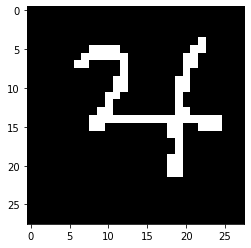

In [ ]:
plt.imshow(pixels_new[0, :, :, 0], cmap='Greys')

In [ ]:
# Iterate the pixels because generation has to be done sequentially pixel by pixel.
# for row in range(rows):
#     for col in range(cols):
#         for channel in range(channels):
            # Feed the whole array and retrieving the pixel value probabilities for the next pixel.
            # ps = model.predict_on_batch(pixels)[channel][:, row*cols+col]

            # Use the probabilities to pick a pixel value.
            # Lastly, we normalize the value.
            # pixels[:, row, col, channel] = np.array([np.random.choice(256, p=p) for p in ps]) / 255

# Iterate the generated images and plot them with matplotlib.

IndexError: ignored